### hetGPy `Expected Improvement` example 

This notebook re-creates the example from `crit_EI` in the `hetGP` documentation.

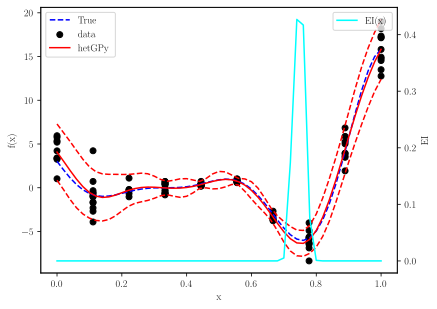

In [1]:
# from hetGP documentation
from hetgpy.hetGP import hetGP
from hetgpy.optim import crit_EI
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from rpy2.robjects import r

# plotting
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

r('''
set.seed(42)
library(hetGP)

## Noise field via standard deviation
noiseFun <- function(x, coef = 1.1, scale = 1){
if(is.null(nrow(x)))
 x <- matrix(x, nrow = 1)
   return(scale*(coef + cos(x * 2 * pi)))
}

## Test function defined in [0,1]
ftest <- function(x){
if(is.null(nrow(x)))
x <- matrix(x, ncol = 1)
return(f1d(x) + rnorm(nrow(x), mean = 0, sd = noiseFun(x)))
}

n_init <- 10 # number of unique designs
N_init <- 100 # total number of points
X <- seq(0, 1, length.out = n_init)
X <- matrix(X[sample(1:n_init, N_init, replace = TRUE)], ncol = 1)
Z <- ftest(X)
ngrid <- 51
xgrid <- seq(0,1, length.out = ngrid)
''')

## Predictive grid
ngrid = 51
xgrid = np.linspace(0,1, ngrid)
Xgrid = xgrid.reshape(-1,1)

X = np.array(r('X'))
Z = np.array(r('Z')).squeeze()
f1d_xgrid = np.array(r('f1d(xgrid)'))
model = hetGP() 
model.mleHetGP(X = X, Z = Z, lower = np.array([0.001]), upper = np.array([1.0]), 
               known = {}, init = {},maxit=5e3,settings={'factr':10},covtype = "Matern5_2")

EIgrid = crit_EI(Xgrid, model)
preds = model.predict(x = Xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()

f, ax = plt.subplots(nrows = 1, ncols = 1)

ax.plot(xgrid,f1d_xgrid,color='blue',linestyle='dashed',label='True') # true
ax.scatter(X.squeeze(),Z,color='black',label = 'data')                   # data 

ax.plot(xgrid,preds['mean'],color='red',label='hetGPy')                  # mean
ax.plot(xgrid,preds['lower'],color='red',linestyle='dashed') 
ax.plot(xgrid,preds['upper'],color='red',linestyle='dashed') 
ax.set_ylabel('f(x)')
ax.set_xlabel('x')

ax2 = ax.twinx()
ax2.plot(xgrid,EIgrid,color='cyan',label='EI(x)')
ax2.set_ylabel('EI')
# Legends
ax.legend()
ax2.legend()